In [85]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [87]:
cd 'My Drive'

[Errno 2] No such file or directory: 'My Drive'
/content/gdrive/My Drive


In [0]:
# Python 2.7
# By: Amin Mansouri

# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import pickle
from sklearn.model_selection import train_test_split

tf.reset_default_graph()

# image data input (img shape: 28*28)
n_input = 28

n_classes = 10
std = 0.1
epsilon = 1e-5

training_iterations = 10
learning_rate = 0.001
batch_size = 64
keep_prob_input = 0.8

weights = {
    'weight_conv_layer_1': tf.get_variable('W0', shape=(7, 7, 1, 64),
                                           initializer=tf.initializers.random_normal(stddev=std)
                                           ),
    'weight_conv_layer_2': tf.get_variable('W1', shape=(7, 7, 64, 64),
                                           initializer=tf.initializers.random_normal(stddev=std)),
    'weight_conv_layer_3': tf.get_variable('W2', shape=(7, 7, 64, 128),
                                           initializer=tf.initializers.random_normal(stddev=std)),
    'weight_conv_layer_4': tf.get_variable('W3', shape=(7, 7, 128, 128),
                                           initializer=tf.initializers.random_normal(stddev=std)),
    'weight_conv_layer_5': tf.get_variable('W4', shape=(7, 7, 128, 256),
                                           initializer=tf.initializers.random_normal(stddev=std)),
    'weight_conv_layer_6': tf.get_variable('W5', shape=(7, 7, 256, 256),
                                           initializer=tf.initializers.random_normal(stddev=std)),

    'w_fc': tf.get_variable('W_fc', shape=(7 * 7 * 256, 256), initializer=tf.initializers.random_normal(stddev=std)),
    
    'w_fc2': tf.get_variable('W_fc2', shape=(256, 256), initializer=tf.initializers.random_normal(stddev=std)),
    'w_fc3': tf.get_variable('W_fc3', shape=(256, 256), initializer=tf.initializers.random_normal(stddev=std)),
    'out': tf.get_variable('W_out', shape=(256, n_classes), initializer=tf.initializers.random_normal(stddev=std)),
}
biases = {
    'bias_conv_layer_1': tf.get_variable('B0', shape=64, initializer=tf.initializers.random_normal(stddev=std)),
    'bias_conv_layer_2': tf.get_variable('B1', shape=64, initializer=tf.initializers.random_normal(stddev=std)),
    'bias_conv_layer_3': tf.get_variable('B2', shape=128, initializer=tf.initializers.random_normal(stddev=std)),
    'bias_conv_layer_4': tf.get_variable('B3', shape=128, initializer=tf.initializers.random_normal(stddev=std)),
    'bias_conv_layer_5': tf.get_variable('B4', shape=256, initializer=tf.initializers.random_normal(stddev=std)),
    'bias_conv_layer_6': tf.get_variable('B5', shape=256, initializer=tf.initializers.random_normal(stddev=std)),
    # 'bias_conv_layer_3': tf.get_variable('B2', shape=128, initializer=tf.contrib.layers.xavier_initializer()),
    'b_fc': tf.get_variable('B_fc', shape=256, initializer=tf.initializers.random_normal(stddev=std)),
    'b_fc2': tf.get_variable('B_fc2', shape=256, initializer=tf.initializers.random_normal(stddev=std)),
    'b_fc3': tf.get_variable('B_fc3', shape=256, initializer=tf.initializers.random_normal(stddev=std)),
    'out': tf.get_variable('B_out', shape=n_classes, initializer=tf.initializers.random_normal(stddev=std)),
}


def next_batch(num, data, labels):

    """Return a total of `num` random samples and labels."""
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)


# noinspection PyShadowingNames
def conv2d(x, w, b, strides=1):
    # Conv2D wrapper, with bias and ReLU activation
    x = tf.nn.conv2d(x, w, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')


def next_batch(num, data, labels):

    """Return a total of `num` random samples and labels."""
    idx = np.arange(0, len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [0]:
pickle_in = open('train.data', 'rb')
train_data = pickle.load(pickle_in)

# pickle_in = open('test.data', 'rb')
# test_data = pickle.load(pickle_in)

x_train, x_validation, y_train, y_validation = train_test_split(train_data['data'], train_data['labels'], test_size=0.2)

# both placeholders are of type float
x = tf.placeholder("float", [None, 28, 28, 1])
# x = tf.placeholder("float", [28, 28])
y = tf.placeholder("float", [None, n_classes])

keep_prob = tf.placeholder(tf.float32)


In [0]:
# Dropout
x = tf.nn.dropout(x, keep_prob=keep_prob_input)

# here we call the conv2d function we had defined above and pass the input image x, weights weight_conv_layer_1
# and bias bias_conv_layer_1.
conv1 = conv2d(x, weights['weight_conv_layer_1'], biases['bias_conv_layer_1'], strides=2)
# Max Pooling (down-sampling), this chooses the max value from a 2*2 matrix window and outputs a 14*14 matrix.
conv1_maxpool = maxpool2d(conv1, k=1)
batch_mean_1, batch_var_1 = tf.nn.moments(conv1_maxpool, [0])
beta_1 = tf.Variable(tf.zeros(conv1_maxpool.get_shape().as_list()[1:]))
scale_1 = tf.Variable(tf.zeros(conv1_maxpool.get_shape().as_list()[1:]))
conv1_maxpool = tf.nn.batch_normalization(conv1_maxpool, batch_mean_1, batch_var_1, offset=beta_1, scale=scale_1, variance_epsilon=epsilon)

# Dropout
conv1_maxpool = tf.nn.dropout(conv1_maxpool, keep_prob=keep_prob)

conv2 = conv2d(conv1_maxpool, weights['weight_conv_layer_2'], biases['bias_conv_layer_2'], strides=2)
conv2_maxpool = maxpool2d(conv2, k=1)
batch_mean_2, batch_var_2 = tf.nn.moments(conv2_maxpool, [0])
beta_2 = tf.Variable(tf.zeros(conv2_maxpool.get_shape().as_list()[1:]))
scale_2 = tf.Variable(tf.zeros(conv2_maxpool.get_shape().as_list()[1:]))
conv2_maxpool = tf.nn.batch_normalization(conv2_maxpool, batch_mean_2, batch_var_2, offset=beta_2, scale=scale_2, variance_epsilon=epsilon)

# Dropout
conv2_maxpool = tf.nn.dropout(conv2_maxpool, keep_prob=keep_prob)

conv3 = conv2d(conv2_maxpool, weights['weight_conv_layer_3'], biases['bias_conv_layer_3'], strides=1)
batch_mean_3, batch_var_3 = tf.nn.moments(conv3, [0])
beta_3 = tf.Variable(tf.zeros(conv3.get_shape().as_list()[1:]))
scale_3 = tf.Variable(tf.zeros(conv3.get_shape().as_list()[1:]))
conv3 = tf.nn.batch_normalization(conv3, batch_mean_3, batch_var_3, offset=beta_3, scale=scale_3, variance_epsilon=epsilon)

# Dropout
conv3 = tf.nn.dropout(conv3, keep_prob=keep_prob)

conv4 = conv2d(conv3, weights['weight_conv_layer_4'], biases['bias_conv_layer_4'], strides=1)
batch_mean_4, batch_var_4 = tf.nn.moments(conv4, [0])
beta_4 = tf.Variable(tf.zeros(conv4.get_shape().as_list()[1:]))
scale_4 = tf.Variable(tf.zeros(conv4.get_shape().as_list()[1:]))
conv4 = tf.nn.batch_normalization(conv4, batch_mean_4, batch_var_4, offset=beta_4, scale=scale_4, variance_epsilon=epsilon)

# Dropout
conv4 = tf.nn.dropout(conv4, keep_prob=keep_prob)

conv5 = conv2d(conv4, weights['weight_conv_layer_5'], biases['bias_conv_layer_5'], strides=1)
batch_mean_5, batch_var_5 = tf.nn.moments(conv5, [0])
beta_5 = tf.Variable(tf.zeros(conv5.get_shape().as_list()[1:]))
scale_5 = tf.Variable(tf.zeros(conv5.get_shape().as_list()[1:]))
conv5 = tf.nn.batch_normalization(conv5, batch_mean_5, batch_var_5, offset=beta_5, scale=scale_5, variance_epsilon=epsilon)

# Dropout
conv5 = tf.nn.dropout(conv5, keep_prob=keep_prob)

conv6 = conv2d(conv5, weights['weight_conv_layer_6'], biases['bias_conv_layer_6'], strides=1)
batch_mean_6, batch_var_6 = tf.nn.moments(conv5, [0])
beta_6 = tf.Variable(tf.zeros(conv6.get_shape().as_list()[1:]))
scale_6 = tf.Variable(tf.zeros(conv6.get_shape().as_list()[1:]))
conv6 = tf.nn.batch_normalization(conv6, batch_mean_6, batch_var_6, offset=beta_6, scale=scale_6, variance_epsilon=epsilon)

# Dropout
conv6 = tf.nn.dropout(conv6, keep_prob=keep_prob)

# Fully connected layer
# Reshape conv6 output to fit fully connected layer input
fc1 = tf.reshape(conv6, [-1, weights['w_fc'].get_shape().as_list()[0]])
fc1 = tf.add(tf.matmul(fc1, weights['w_fc']), biases['b_fc'])
fc1 = tf.nn.relu(fc1)

fc2 = tf.reshape(fc1, [-1, weights['w_fc2'].get_shape().as_list()[0]])
fc2 = tf.add(tf.matmul(fc2, weights['w_fc2']), biases['b_fc2'])
fc2 = tf.nn.relu(fc2)

fc3 = tf.reshape(fc2, [-1, weights['w_fc3'].get_shape().as_list()[0]])
fc3 = tf.add(tf.matmul(fc3, weights['w_fc3']), biases['b_fc3'])
fc3 = tf.nn.relu(fc3)

# Output, class prediction
# finally we multiply the fully connected layer with the weights and add a bias term.
out = tf.add(tf.matmul(fc3, weights['out']), biases['out'])


In [0]:
prediction = out

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Here you check whether the index of the maximum value of the predicted image is equal to the actual labelled image.
#  and both will be a column vector.
correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))

confusion_matrix = tf.confusion_matrix(tf.argmax(prediction, 1), tf.argmax(y, 1), num_classes=10)
# calculate accuracy across all the given images and average them out.
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# summary settings:

train_loss_summary = tf.summary.scalar('loss_train', cost)
train_accuracy_summary = tf.summary.scalar('train_accuracy', accuracy)
train_summaries = tf.summary.merge([train_loss_summary, train_accuracy_summary])
# file_writer = tf.summary.FileWriter('./Output', sess.graph)

validation_loss_summary = tf.summary.scalar('loss_validation', cost)
validation_accuracy_summary = tf.summary.scalar('validation_accuracy', accuracy)
validation_summaries = tf.summary.merge([validation_loss_summary, validation_accuracy_summary])
# validation_file_writer = tf.summary.FileWriter(output_folder)

# Initializing the variables
init = tf.global_variables_initializer()

saver = tf.train.Saver()

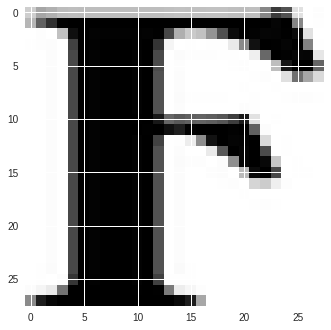

[(32000, 28, 28, 1), (8000, 28, 28, 1)]
(32000, 10) (8000, 10)


In [95]:
curr_img = np.reshape(x_train[1], (28, 28))
curr_lbl = np.argmax(y_train[1, :])
plt.imshow(curr_img)
plt.show()

# Reshape training and testing image
train_X = x_train.reshape(-1, 28, 28, 1)
test_X = x_validation.reshape(-1, 28, 28, 1)

print([train_X.shape, test_X.shape])

train_y = y_train
test_y = y_validation

print(train_y.shape, test_y.shape)





In [96]:
# Batch Mode Learning

counter = 0
disp_counter = 20

mis_classified_idx = []

with tf.Session() as sess:
    sess.run(init)

    merge = tf.summary.merge_all()
    summary_writer_train = tf.summary.FileWriter('./CNNIII_train', sess.graph)
    summary_writer_validation = tf.summary.FileWriter('./CNNIII_validation', sess.graph)

    # ########################################## Training ########################################## #

    for i in range(training_iterations):

        # for batch in tqdm(range(len(train_X) // batch_size // training_iterations)):
        #
        #     counter += 1
        #     batch_x = train_X[(batch + i * len(train_X) // batch_size // training_iterations) *
        #                       batch_size:min((batch + 1 + i * len(train_X) // batch_size // training_iterations) *
        #                                      batch_size, len(train_X))]
        #     batch_y = train_y[(batch + i * len(train_X) // batch_size // training_iterations) *
        #                       batch_size:min((batch + 1 + i * len(train_X) // batch_size // training_iterations) *
        #                                      batch_size, len(train_y))]

        for batch in tqdm(range(len(train_X) // batch_size)):

            counter += 1
            batch_x, batch_y = next_batch(batch_size, train_X, train_y)

            # Run optimization op (backprop).
            # Calculate batch loss and accuracy
            opt = sess.run(optimizer, feed_dict={x: batch_x,
                                                 y: batch_y, keep_prob: 0.5})
            loss, acc = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                              y: batch_y, keep_prob: 0.5})

            # summary_writer_train.add_summary(
            #     (sess.run(train_summaries, feed_dict={x: batch_x,
            #                                           y: batch_y, keep_prob: 0.5})), batch)

            if counter % disp_counter == 0:

                print("Iter " + str(i) + ", Loss= " + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc)
                      )
                print("Optimization Finished!")

        x_batch, y_batch = next_batch(batch_size, x_train, y_train)
        summary_writer_train.add_summary((sess.run(train_loss_summary, feed_dict={x: x_batch, y: y_batch, keep_prob: 0.5})), i)

        x_batch, y_batch = next_batch(batch_size, x_validation, y_validation)
        summary_writer_validation.add_summary(sess.run(validation_loss_summary, feed_dict={x: x_batch, y: y_batch, keep_prob: 1.0}), i)

    # ########################################## Testing ########################################## #

    counter = 0

    while counter <= len(x_validation):
        counter += 1

        x_batch, y_batch = next_batch(1, x_validation, y_validation)
        # summary_writer_validation.add_summary((sess.run(validation_loss_summary, feed_dict={x: x_batch, y: y_batch, keep_prob: 1.0})), counter)

        prediction_result = sess.run(correct_prediction, feed_dict={x: x_batch, y: y_batch, keep_prob: 1.0})
        prediction_result = np.bool(prediction_result)
        # print(type(prediction_result))
        # print(prediction_result)
        if prediction_result:
            # print('hello')
            mis_classified_idx.append(counter)
            # print('prediction for valid id: ' + str(counter) + 'is: ' + str(prediction_result) + ' which is FALSE')

    # Calculate accuracy for all test images
    x_batch, y_batch = x_validation, y_validation
    accuracy_test, loss_test = sess.run((accuracy, cost), feed_dict={x: x_batch, y: y_batch, keep_prob: 1.0})
    cm = sess.run(confusion_matrix, feed_dict={x: x_batch, y: y_batch, keep_prob: 1.0})
    print(cm)
    print("The test accuracy is:" + str(accuracy_test))

    summary_writer_train.close()
    summary_writer_validation.close()

# For future use: tensorboard --logdir=train:./Output_train,validation:./Output_validation,conv_1:./conv_1_filters,
# conv2:./conv_2_filters


  4%|▍         | 22/500 [00:02<00:40, 11.84it/s]

Iter 0, Loss= 2.342441, Training Accuracy= 0.14062
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.43it/s]

Iter 0, Loss= 2.389782, Training Accuracy= 0.15625
Optimization Finished!


 12%|█▏        | 62/500 [00:05<00:35, 12.41it/s]

Iter 0, Loss= 2.354382, Training Accuracy= 0.07812
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.47it/s]

Iter 0, Loss= 2.368416, Training Accuracy= 0.06250
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.53it/s]

Iter 0, Loss= 2.450404, Training Accuracy= 0.04688
Optimization Finished!


 24%|██▍       | 122/500 [00:10<00:30, 12.39it/s]

Iter 0, Loss= 2.314420, Training Accuracy= 0.09375
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.48it/s]

Iter 0, Loss= 2.352127, Training Accuracy= 0.12500
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.51it/s]

Iter 0, Loss= 2.376783, Training Accuracy= 0.09375
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.46it/s]

Iter 0, Loss= 2.330233, Training Accuracy= 0.06250
Optimization Finished!


 40%|████      | 202/500 [00:16<00:24, 12.29it/s]

Iter 0, Loss= 2.274521, Training Accuracy= 0.14062
Optimization Finished!


 44%|████▍     | 222/500 [00:18<00:22, 12.49it/s]

Iter 0, Loss= 2.342765, Training Accuracy= 0.07812
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.44it/s]

Iter 0, Loss= 2.349623, Training Accuracy= 0.10938
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:18, 12.59it/s]

Iter 0, Loss= 2.340982, Training Accuracy= 0.14062
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.45it/s]

Iter 0, Loss= 2.334146, Training Accuracy= 0.03125
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.63it/s]

Iter 0, Loss= 2.343836, Training Accuracy= 0.10938
Optimization Finished!


 64%|██████▍   | 322/500 [00:26<00:14, 12.56it/s]

Iter 0, Loss= 2.309578, Training Accuracy= 0.10938
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.40it/s]

Iter 0, Loss= 2.279463, Training Accuracy= 0.12500
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.41it/s]

Iter 0, Loss= 2.301615, Training Accuracy= 0.10938
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.52it/s]

Iter 0, Loss= 2.294131, Training Accuracy= 0.15625
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.48it/s]

Iter 0, Loss= 2.346412, Training Accuracy= 0.01562
Optimization Finished!


 84%|████████▍ | 422/500 [00:34<00:06, 12.51it/s]

Iter 0, Loss= 2.311016, Training Accuracy= 0.18750
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.45it/s]

Iter 0, Loss= 2.282202, Training Accuracy= 0.14062
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.51it/s]

Iter 0, Loss= 2.337230, Training Accuracy= 0.07812
Optimization Finished!


 96%|█████████▋| 482/500 [00:39<00:01, 12.37it/s]

Iter 0, Loss= 2.294590, Training Accuracy= 0.14062
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 0, Loss= 2.293743, Training Accuracy= 0.09375
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.51it/s]

Iter 1, Loss= 2.212375, Training Accuracy= 0.12500
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.56it/s]

Iter 1, Loss= 2.062831, Training Accuracy= 0.15625
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.45it/s]

Iter 1, Loss= 2.140186, Training Accuracy= 0.18750
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.48it/s]

Iter 1, Loss= 1.963211, Training Accuracy= 0.28125
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.49it/s]

Iter 1, Loss= 2.216539, Training Accuracy= 0.18750
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:31, 12.18it/s]

Iter 1, Loss= 1.765814, Training Accuracy= 0.21875
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.37it/s]

Iter 1, Loss= 1.906069, Training Accuracy= 0.31250
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.44it/s]

Iter 1, Loss= 1.762588, Training Accuracy= 0.25000
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.48it/s]

Iter 1, Loss= 1.577607, Training Accuracy= 0.42188
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.50it/s]

Iter 1, Loss= 1.805679, Training Accuracy= 0.31250
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.38it/s]

Iter 1, Loss= 1.671366, Training Accuracy= 0.26562
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.40it/s]

Iter 1, Loss= 1.692639, Training Accuracy= 0.39062
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.33it/s]

Iter 1, Loss= 1.733801, Training Accuracy= 0.29688
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.43it/s]

Iter 1, Loss= 1.613557, Training Accuracy= 0.35938
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:16, 12.32it/s]

Iter 1, Loss= 1.538959, Training Accuracy= 0.46875
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.46it/s]

Iter 1, Loss= 1.384718, Training Accuracy= 0.45312
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.34it/s]

Iter 1, Loss= 1.450065, Training Accuracy= 0.45312
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.46it/s]

Iter 1, Loss= 1.473956, Training Accuracy= 0.42188
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.43it/s]

Iter 1, Loss= 1.385523, Training Accuracy= 0.60938
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.44it/s]

Iter 1, Loss= 1.310652, Training Accuracy= 0.50000
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.49it/s]

Iter 1, Loss= 1.280813, Training Accuracy= 0.50000
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.42it/s]

Iter 1, Loss= 1.229365, Training Accuracy= 0.57812
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.58it/s]

Iter 1, Loss= 1.159591, Training Accuracy= 0.54688
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.54it/s]

Iter 1, Loss= 0.933789, Training Accuracy= 0.71875
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 1, Loss= 0.926474, Training Accuracy= 0.75000
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.44it/s]

Iter 2, Loss= 1.121744, Training Accuracy= 0.59375
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.45it/s]

Iter 2, Loss= 1.122386, Training Accuracy= 0.67188
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.42it/s]

Iter 2, Loss= 0.951866, Training Accuracy= 0.67188
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.41it/s]

Iter 2, Loss= 0.881548, Training Accuracy= 0.67188
Optimization Finished!


 20%|██        | 102/500 [00:08<00:32, 12.42it/s]

Iter 2, Loss= 0.905295, Training Accuracy= 0.68750
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.41it/s]

Iter 2, Loss= 0.925302, Training Accuracy= 0.73438
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.51it/s]

Iter 2, Loss= 0.769801, Training Accuracy= 0.71875
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.41it/s]

Iter 2, Loss= 0.908404, Training Accuracy= 0.71875
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.35it/s]

Iter 2, Loss= 1.128751, Training Accuracy= 0.68750
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.45it/s]

Iter 2, Loss= 1.010943, Training Accuracy= 0.68750
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.34it/s]

Iter 2, Loss= 0.660153, Training Accuracy= 0.76562
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.54it/s]

Iter 2, Loss= 1.015608, Training Accuracy= 0.70312
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.37it/s]

Iter 2, Loss= 1.024156, Training Accuracy= 0.65625
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.36it/s]

Iter 2, Loss= 1.025305, Training Accuracy= 0.64062
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.43it/s]

Iter 2, Loss= 1.130502, Training Accuracy= 0.62500
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.47it/s]

Iter 2, Loss= 0.645553, Training Accuracy= 0.76562
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.50it/s]

Iter 2, Loss= 0.908025, Training Accuracy= 0.75000
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.38it/s]

Iter 2, Loss= 0.600971, Training Accuracy= 0.82812
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.46it/s]

Iter 2, Loss= 0.624790, Training Accuracy= 0.82812
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.54it/s]

Iter 2, Loss= 0.660574, Training Accuracy= 0.81250
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.48it/s]

Iter 2, Loss= 0.564857, Training Accuracy= 0.82812
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.43it/s]

Iter 2, Loss= 0.653541, Training Accuracy= 0.76562
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.52it/s]

Iter 2, Loss= 0.811530, Training Accuracy= 0.75000
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.44it/s]

Iter 2, Loss= 0.676022, Training Accuracy= 0.78125
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 2, Loss= 0.779787, Training Accuracy= 0.78125
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.45it/s]

Iter 3, Loss= 0.947007, Training Accuracy= 0.73438
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.50it/s]

Iter 3, Loss= 0.837732, Training Accuracy= 0.67188
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.51it/s]

Iter 3, Loss= 0.992983, Training Accuracy= 0.75000
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.42it/s]

Iter 3, Loss= 0.599266, Training Accuracy= 0.81250
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.54it/s]

Iter 3, Loss= 0.628016, Training Accuracy= 0.82812
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.51it/s]

Iter 3, Loss= 0.631353, Training Accuracy= 0.79688
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.47it/s]

Iter 3, Loss= 0.660796, Training Accuracy= 0.82812
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.37it/s]

Iter 3, Loss= 0.825619, Training Accuracy= 0.75000
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.52it/s]

Iter 3, Loss= 0.508481, Training Accuracy= 0.82812
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.48it/s]

Iter 3, Loss= 0.454781, Training Accuracy= 0.85938
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.41it/s]

Iter 3, Loss= 0.688193, Training Accuracy= 0.75000
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.38it/s]

Iter 3, Loss= 0.814984, Training Accuracy= 0.76562
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.32it/s]

Iter 3, Loss= 0.592649, Training Accuracy= 0.82812
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.39it/s]

Iter 3, Loss= 0.479466, Training Accuracy= 0.84375
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.49it/s]

Iter 3, Loss= 0.826648, Training Accuracy= 0.73438
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.49it/s]

Iter 3, Loss= 0.684161, Training Accuracy= 0.82812
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.44it/s]

Iter 3, Loss= 0.493594, Training Accuracy= 0.85938
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.48it/s]

Iter 3, Loss= 0.596237, Training Accuracy= 0.82812
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.43it/s]

Iter 3, Loss= 0.777234, Training Accuracy= 0.81250
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.43it/s]

Iter 3, Loss= 1.028504, Training Accuracy= 0.71875
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.51it/s]

Iter 3, Loss= 0.716528, Training Accuracy= 0.81250
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.35it/s]

Iter 3, Loss= 0.399848, Training Accuracy= 0.89062
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.37it/s]

Iter 3, Loss= 0.564561, Training Accuracy= 0.82812
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.49it/s]

Iter 3, Loss= 0.480047, Training Accuracy= 0.89062
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 3, Loss= 0.332707, Training Accuracy= 0.92188
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.43it/s]

Iter 4, Loss= 0.478959, Training Accuracy= 0.85938
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.46it/s]

Iter 4, Loss= 0.403129, Training Accuracy= 0.89062
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.37it/s]

Iter 4, Loss= 0.666255, Training Accuracy= 0.73438
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.39it/s]

Iter 4, Loss= 0.600261, Training Accuracy= 0.81250
Optimization Finished!


 20%|██        | 102/500 [00:08<00:32, 12.30it/s]

Iter 4, Loss= 0.446416, Training Accuracy= 0.84375
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.44it/s]

Iter 4, Loss= 0.567729, Training Accuracy= 0.81250
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.41it/s]

Iter 4, Loss= 0.507192, Training Accuracy= 0.82812
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.33it/s]

Iter 4, Loss= 0.755374, Training Accuracy= 0.76562
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.37it/s]

Iter 4, Loss= 0.385036, Training Accuracy= 0.89062
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.50it/s]

Iter 4, Loss= 0.674287, Training Accuracy= 0.81250
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.45it/s]

Iter 4, Loss= 0.540296, Training Accuracy= 0.85938
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.30it/s]

Iter 4, Loss= 0.444516, Training Accuracy= 0.85938
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.40it/s]

Iter 4, Loss= 0.692184, Training Accuracy= 0.81250
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.49it/s]

Iter 4, Loss= 0.429344, Training Accuracy= 0.90625
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.55it/s]

Iter 4, Loss= 0.333636, Training Accuracy= 0.90625
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.52it/s]

Iter 4, Loss= 0.670216, Training Accuracy= 0.81250
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.57it/s]

Iter 4, Loss= 0.610532, Training Accuracy= 0.79688
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.32it/s]

Iter 4, Loss= 0.490209, Training Accuracy= 0.84375
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.48it/s]

Iter 4, Loss= 0.816552, Training Accuracy= 0.82812
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.57it/s]

Iter 4, Loss= 0.531541, Training Accuracy= 0.81250
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.32it/s]

Iter 4, Loss= 0.709382, Training Accuracy= 0.82812
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.48it/s]

Iter 4, Loss= 0.649782, Training Accuracy= 0.82812
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.46it/s]

Iter 4, Loss= 0.611059, Training Accuracy= 0.82812
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.53it/s]

Iter 4, Loss= 0.563434, Training Accuracy= 0.79688
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 4, Loss= 0.533618, Training Accuracy= 0.85938
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.38it/s]

Iter 5, Loss= 0.894895, Training Accuracy= 0.76562
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:37, 12.35it/s]

Iter 5, Loss= 0.760819, Training Accuracy= 0.75000
Optimization Finished!


 12%|█▏        | 62/500 [00:05<00:35, 12.44it/s]

Iter 5, Loss= 0.540738, Training Accuracy= 0.87500
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.43it/s]

Iter 5, Loss= 0.379058, Training Accuracy= 0.89062
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.56it/s]

Iter 5, Loss= 0.491830, Training Accuracy= 0.90625
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.40it/s]

Iter 5, Loss= 0.414990, Training Accuracy= 0.89062
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:29, 12.31it/s]

Iter 5, Loss= 0.673010, Training Accuracy= 0.78125
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.43it/s]

Iter 5, Loss= 0.423882, Training Accuracy= 0.85938
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.28it/s]

Iter 5, Loss= 0.427842, Training Accuracy= 0.84375
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.45it/s]

Iter 5, Loss= 0.603599, Training Accuracy= 0.84375
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.47it/s]

Iter 5, Loss= 0.418659, Training Accuracy= 0.85938
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.40it/s]

Iter 5, Loss= 0.583779, Training Accuracy= 0.82812
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.38it/s]

Iter 5, Loss= 0.339948, Training Accuracy= 0.87500
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.40it/s]

Iter 5, Loss= 0.389544, Training Accuracy= 0.90625
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.53it/s]

Iter 5, Loss= 0.570213, Training Accuracy= 0.84375
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.42it/s]

Iter 5, Loss= 0.562212, Training Accuracy= 0.87500
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.48it/s]

Iter 5, Loss= 0.439772, Training Accuracy= 0.85938
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.46it/s]

Iter 5, Loss= 0.546190, Training Accuracy= 0.79688
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.45it/s]

Iter 5, Loss= 0.371365, Training Accuracy= 0.89062
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.50it/s]

Iter 5, Loss= 0.372062, Training Accuracy= 0.85938
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.51it/s]

Iter 5, Loss= 0.566022, Training Accuracy= 0.81250
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.47it/s]

Iter 5, Loss= 0.510442, Training Accuracy= 0.84375
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.40it/s]

Iter 5, Loss= 0.561002, Training Accuracy= 0.81250
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.49it/s]

Iter 5, Loss= 0.648585, Training Accuracy= 0.78125
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 5, Loss= 0.422253, Training Accuracy= 0.90625
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.46it/s]

Iter 6, Loss= 0.397798, Training Accuracy= 0.85938
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.46it/s]

Iter 6, Loss= 0.444503, Training Accuracy= 0.84375
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.40it/s]

Iter 6, Loss= 0.580375, Training Accuracy= 0.79688
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.48it/s]

Iter 6, Loss= 0.582969, Training Accuracy= 0.84375
Optimization Finished!


 20%|██        | 102/500 [00:08<00:32, 12.37it/s]

Iter 6, Loss= 0.504328, Training Accuracy= 0.85938
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.41it/s]

Iter 6, Loss= 0.367577, Training Accuracy= 0.87500
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.44it/s]

Iter 6, Loss= 0.267847, Training Accuracy= 0.95312
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:27, 12.40it/s]

Iter 6, Loss= 0.688468, Training Accuracy= 0.81250
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.39it/s]

Iter 6, Loss= 0.329505, Training Accuracy= 0.89062
Optimization Finished!


 40%|████      | 202/500 [00:16<00:24, 12.39it/s]

Iter 6, Loss= 0.504601, Training Accuracy= 0.87500
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.50it/s]

Iter 6, Loss= 0.835474, Training Accuracy= 0.76562
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.44it/s]

Iter 6, Loss= 0.575612, Training Accuracy= 0.78125
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.43it/s]

Iter 6, Loss= 0.365288, Training Accuracy= 0.90625
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.26it/s]

Iter 6, Loss= 0.575745, Training Accuracy= 0.81250
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.50it/s]

Iter 6, Loss= 0.384144, Training Accuracy= 0.90625
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.39it/s]

Iter 6, Loss= 0.576105, Training Accuracy= 0.84375
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.38it/s]

Iter 6, Loss= 0.459666, Training Accuracy= 0.87500
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.52it/s]

Iter 6, Loss= 0.379816, Training Accuracy= 0.87500
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.46it/s]

Iter 6, Loss= 0.273832, Training Accuracy= 0.89062
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.41it/s]

Iter 6, Loss= 0.370114, Training Accuracy= 0.89062
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.41it/s]

Iter 6, Loss= 0.460122, Training Accuracy= 0.82812
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.42it/s]

Iter 6, Loss= 0.569120, Training Accuracy= 0.81250
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.39it/s]

Iter 6, Loss= 0.665543, Training Accuracy= 0.76562
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.33it/s]

Iter 6, Loss= 0.597491, Training Accuracy= 0.84375
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 6, Loss= 0.611759, Training Accuracy= 0.82812
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.39it/s]

Iter 7, Loss= 0.348355, Training Accuracy= 0.89062
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.40it/s]

Iter 7, Loss= 0.344220, Training Accuracy= 0.90625
Optimization Finished!


 12%|█▏        | 62/500 [00:05<00:35, 12.33it/s]

Iter 7, Loss= 0.590833, Training Accuracy= 0.79688
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.49it/s]

Iter 7, Loss= 0.487605, Training Accuracy= 0.81250
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.54it/s]

Iter 7, Loss= 0.451245, Training Accuracy= 0.89062
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.43it/s]

Iter 7, Loss= 0.482805, Training Accuracy= 0.84375
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.42it/s]

Iter 7, Loss= 0.461617, Training Accuracy= 0.87500
Optimization Finished!


 32%|███▏      | 162/500 [00:13<00:26, 12.54it/s]

Iter 7, Loss= 0.390792, Training Accuracy= 0.89062
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.46it/s]

Iter 7, Loss= 0.393474, Training Accuracy= 0.85938
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.42it/s]

Iter 7, Loss= 0.449738, Training Accuracy= 0.90625
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.42it/s]

Iter 7, Loss= 0.431204, Training Accuracy= 0.87500
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.37it/s]

Iter 7, Loss= 0.410775, Training Accuracy= 0.85938
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:18, 12.56it/s]

Iter 7, Loss= 0.400553, Training Accuracy= 0.85938
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.41it/s]

Iter 7, Loss= 0.471489, Training Accuracy= 0.85938
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.43it/s]

Iter 7, Loss= 0.470754, Training Accuracy= 0.81250
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.50it/s]

Iter 7, Loss= 0.730830, Training Accuracy= 0.73438
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.59it/s]

Iter 7, Loss= 0.448030, Training Accuracy= 0.85938
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.49it/s]

Iter 7, Loss= 0.662076, Training Accuracy= 0.79688
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.46it/s]

Iter 7, Loss= 0.512336, Training Accuracy= 0.89062
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.45it/s]

Iter 7, Loss= 0.395121, Training Accuracy= 0.87500
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.34it/s]

Iter 7, Loss= 0.519758, Training Accuracy= 0.82812
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.48it/s]

Iter 7, Loss= 0.481871, Training Accuracy= 0.82812
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.38it/s]

Iter 7, Loss= 0.362258, Training Accuracy= 0.89062
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.48it/s]

Iter 7, Loss= 0.443614, Training Accuracy= 0.85938
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 7, Loss= 0.327280, Training Accuracy= 0.90625
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.43it/s]

Iter 8, Loss= 0.517439, Training Accuracy= 0.85938
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.50it/s]

Iter 8, Loss= 0.863972, Training Accuracy= 0.75000
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.41it/s]

Iter 8, Loss= 0.324795, Training Accuracy= 0.89062
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.59it/s]

Iter 8, Loss= 0.585063, Training Accuracy= 0.79688
Optimization Finished!


 20%|██        | 102/500 [00:08<00:32, 12.33it/s]

Iter 8, Loss= 0.449618, Training Accuracy= 0.89062
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.44it/s]

Iter 8, Loss= 0.425803, Training Accuracy= 0.87500
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.38it/s]

Iter 8, Loss= 0.436276, Training Accuracy= 0.85938
Optimization Finished!


 32%|███▏      | 162/500 [00:12<00:27, 12.50it/s]

Iter 8, Loss= 0.545912, Training Accuracy= 0.85938
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.48it/s]

Iter 8, Loss= 0.464866, Training Accuracy= 0.89062
Optimization Finished!


 40%|████      | 202/500 [00:16<00:24, 12.29it/s]

Iter 8, Loss= 0.479531, Training Accuracy= 0.87500
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.48it/s]

Iter 8, Loss= 0.432740, Training Accuracy= 0.85938
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.54it/s]

Iter 8, Loss= 0.270720, Training Accuracy= 0.89062
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.36it/s]

Iter 8, Loss= 0.517921, Training Accuracy= 0.82812
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.41it/s]

Iter 8, Loss= 0.746152, Training Accuracy= 0.84375
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.48it/s]

Iter 8, Loss= 0.534637, Training Accuracy= 0.84375
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.45it/s]

Iter 8, Loss= 0.318337, Training Accuracy= 0.90625
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.50it/s]

Iter 8, Loss= 0.622181, Training Accuracy= 0.81250
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.54it/s]

Iter 8, Loss= 0.383878, Training Accuracy= 0.87500
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.41it/s]

Iter 8, Loss= 0.347499, Training Accuracy= 0.89062
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.54it/s]

Iter 8, Loss= 0.326474, Training Accuracy= 0.85938
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.43it/s]

Iter 8, Loss= 0.512832, Training Accuracy= 0.81250
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.42it/s]

Iter 8, Loss= 0.483547, Training Accuracy= 0.87500
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.41it/s]

Iter 8, Loss= 0.282048, Training Accuracy= 0.90625
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.38it/s]

Iter 8, Loss= 0.580659, Training Accuracy= 0.81250
Optimization Finished!


  0%|          | 0/500 [00:00<?, ?it/s]

Iter 8, Loss= 0.411340, Training Accuracy= 0.85938
Optimization Finished!


  4%|▍         | 22/500 [00:01<00:38, 12.33it/s]

Iter 9, Loss= 0.550196, Training Accuracy= 0.82812
Optimization Finished!


  8%|▊         | 42/500 [00:03<00:36, 12.46it/s]

Iter 9, Loss= 0.582297, Training Accuracy= 0.84375
Optimization Finished!


 12%|█▏        | 62/500 [00:04<00:35, 12.40it/s]

Iter 9, Loss= 0.687722, Training Accuracy= 0.84375
Optimization Finished!


 16%|█▋        | 82/500 [00:06<00:33, 12.52it/s]

Iter 9, Loss= 0.363270, Training Accuracy= 0.87500
Optimization Finished!


 20%|██        | 102/500 [00:08<00:31, 12.49it/s]

Iter 9, Loss= 0.541431, Training Accuracy= 0.84375
Optimization Finished!


 24%|██▍       | 122/500 [00:09<00:30, 12.46it/s]

Iter 9, Loss= 0.473356, Training Accuracy= 0.85938
Optimization Finished!


 28%|██▊       | 142/500 [00:11<00:28, 12.50it/s]

Iter 9, Loss= 0.402253, Training Accuracy= 0.85938
Optimization Finished!


 32%|███▏      | 162/500 [00:12<00:27, 12.51it/s]

Iter 9, Loss= 0.507808, Training Accuracy= 0.87500
Optimization Finished!


 36%|███▋      | 182/500 [00:14<00:25, 12.51it/s]

Iter 9, Loss= 0.352989, Training Accuracy= 0.89062
Optimization Finished!


 40%|████      | 202/500 [00:16<00:23, 12.46it/s]

Iter 9, Loss= 0.445803, Training Accuracy= 0.87500
Optimization Finished!


 44%|████▍     | 222/500 [00:17<00:22, 12.59it/s]

Iter 9, Loss= 0.361229, Training Accuracy= 0.85938
Optimization Finished!


 48%|████▊     | 242/500 [00:19<00:20, 12.45it/s]

Iter 9, Loss= 0.456755, Training Accuracy= 0.85938
Optimization Finished!


 52%|█████▏    | 262/500 [00:21<00:19, 12.41it/s]

Iter 9, Loss= 0.690607, Training Accuracy= 0.81250
Optimization Finished!


 56%|█████▋    | 282/500 [00:22<00:17, 12.46it/s]

Iter 9, Loss= 0.582596, Training Accuracy= 0.82812
Optimization Finished!


 60%|██████    | 302/500 [00:24<00:15, 12.47it/s]

Iter 9, Loss= 0.440883, Training Accuracy= 0.82812
Optimization Finished!


 64%|██████▍   | 322/500 [00:25<00:14, 12.30it/s]

Iter 9, Loss= 0.387967, Training Accuracy= 0.87500
Optimization Finished!


 68%|██████▊   | 342/500 [00:27<00:12, 12.39it/s]

Iter 9, Loss= 0.676533, Training Accuracy= 0.81250
Optimization Finished!


 72%|███████▏  | 362/500 [00:29<00:11, 12.44it/s]

Iter 9, Loss= 0.734839, Training Accuracy= 0.79688
Optimization Finished!


 76%|███████▋  | 382/500 [00:30<00:09, 12.39it/s]

Iter 9, Loss= 0.556269, Training Accuracy= 0.81250
Optimization Finished!


 80%|████████  | 402/500 [00:32<00:07, 12.46it/s]

Iter 9, Loss= 0.509597, Training Accuracy= 0.82812
Optimization Finished!


 84%|████████▍ | 422/500 [00:33<00:06, 12.44it/s]

Iter 9, Loss= 0.386842, Training Accuracy= 0.85938
Optimization Finished!


 88%|████████▊ | 442/500 [00:35<00:04, 12.56it/s]

Iter 9, Loss= 0.507009, Training Accuracy= 0.89062
Optimization Finished!


 92%|█████████▏| 462/500 [00:37<00:03, 12.49it/s]

Iter 9, Loss= 0.199573, Training Accuracy= 0.95312
Optimization Finished!


 96%|█████████▋| 482/500 [00:38<00:01, 12.36it/s]

Iter 9, Loss= 0.630633, Training Accuracy= 0.78125
Optimization Finished!


100%|██████████| 500/500 [00:40<00:00, 12.39it/s]


Iter 9, Loss= 0.431069, Training Accuracy= 0.85938
Optimization Finished!
[[757  14   9  14  14   9   7  26  16   9]
 [ 15 719   4  29  18  10  25  10  16  16]
 [  2   1 689   2  17   3  22   3   2   2]
 [  8  13   3 725   4   5   6  15  12   8]
 [  1  12  21   1 745   5   8   5  11   1]
 [  8   3   3   4  14 706   7   4   8   2]
 [  5  15  31   8  15  11 685   2  10   5]
 [  9   4   4   5   5   3   3 717   5   2]
 [ 16  10   8  17  21  14  14  19 661  15]
 [  8   7   2  18   4  16  14   3  49 692]]
The test accuracy is:0.887


In [0]:
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)


In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2019-01-21 19:10:24--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.7.169.168, 52.71.139.107, 52.54.84.112, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.7.169.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5363700 (5.1M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]   5.11M  9.23MB/s    in 0.6s    

2019-01-21 19:10:25 (9.23 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [5363700/5363700]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [0]:
get_ipython().system_raw('./ngrok http 6006 &')

In [0]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://890de7ec.ngrok.io
